# Surface density

## Introduction
- code written by Anezka Majkova (version: 11.12.2024)

In this code, we want to determine the surface density (number of molecules per ${um^2}$) of a fluorescently labeled molecule of interest on our SLB. The surface density is defined

$$ \text{surface density} = \frac{\text{bulk intensity - background intensity} }{ \text{single molecule intensity}} $$


By divison by actual roi size, surface density in **number of molecules per ${um^2}$** is achieved.

Note: upload & analyze data for each SLB well separately 

INPUT: 
- bulk data (.SPE files): data where we want to determine the surface density (no bleaching involved!)
- single-molecule data (.SPE/.h5 files): to extract single-molecule and background intensity → 'mass' and 'bg' in .h5 files (bleaching can be involved to achieve single-molecule densities)

OUTPUT:
- surface density in  $ {\text{number of molecules}/ um^2}$
- plot of individual surface densities within one well, from which the error of the mean is estimated

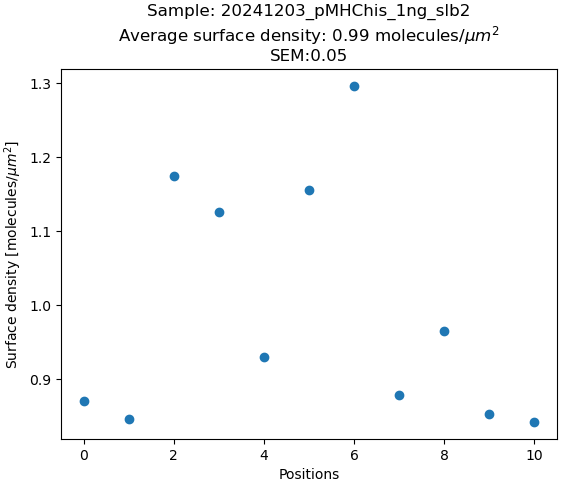


REFERENCE:
- https://schuetzgroup.github.io/sdt-python/
- https://github.com/schuetzgroup/sdt-python


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import pickle

import ipywidgets
from sdt import io, loc, motion, multicolor, nbui, brightness, roi

import trackpy
trackpy.quiet()
import traitlets

import subprocess
import sys

#for progressbar
from tqdm.notebook import tqdm, trange

import pims

import pandas as pd
import matplotlib.image as mpimg

from TOCCSL import *

import tifffile

In [3]:
print(tifffile.__version__)

2022.10.10


# surface density: monomeric molecules
- for monomeric proteins, origami platforms with a single fluorophore, etc.
  - **if bulk data and single-molecule data are included within the same movie**


## User input:

1) set the data directory, filename and frames to be analyzed (bulk data and single-molecule data).

In [4]:
#data path
data_dir= r"/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/positive" 

#filename(s) to analyze
data_filename=['20250725_pos1']

#which frames I want to use for single-molecula data/bulk data
sm_start_frame=4 #first frame of the sm data
sm_final_frame=4 #last frame of the sm data

bulk_start_frame=0 #first frame of the bulk data



2) choose the roi in the image-j (aim for homogenous illumination in your roi), insert the coordinates here

In [5]:
#coordinates of top left corner of the chosen roi
top_left=[290,40]

#coordinates of bottom right corner of the chosen roi
bottom_right=[380,110]


3) here, the roi size is calculated and respective roi is cut from the raw data and saved as .tiff file

In [6]:
#this creates roi based on image-j coordinates
roi_imagej = roi.ROI((top_left[0], top_left[1]), (bottom_right[0], bottom_right[1]))

#size of the chosen roi in pixels, based on the coordinates from imagej
size=[bottom_right[0]-top_left[0],bottom_right[1]-top_left[1]]

#size of the chosen roi in um, based on the coordinates from imagej/image size
size_um=[size[0]*0.160, size[1]*0.160]
    
print('ROI size in pixels:  '+ str(size)+'\n' +'ROI size in um:  '+ str(size_um))

#upload the data images, as a list
data_files = sorted(Path(data_dir).glob(data_filename[0]+'*.SPE'))

#cut & save roi of the data as .tiff file
data_imgs = [io.ImageSequence(b).open() for b in data_files]

#assign left and right roi to all stacks
data_roi = [roi_imagej(i) for i in data_imgs]


for i in range(0, len(data_files)):
    io.save_as_tiff(f'{data_dir}/'+data_filename[0]+'_roi_'+str(i)+'.tiff', data_roi[i])

io.save_as_tiff('test.tiff', data_roi[0])

ROI size in pixels:  [90, 70]
ROI size in um:  [14.4, 11.200000000000001]


4) use locator to localize single-molecule data (.tiff or .SPE files)

In [7]:
#localization (in frames, where individual signals are distinguishable, to extract single-molecule brightness and background)
sys.executable
subprocess.run([sys.executable, "-m", "sdt.gui.locator"])

/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/site-packages/sdt/io/sm.py:439: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  da

CompletedProcess(args=['/opt/anaconda3/envs/sdt-env/bin/python', '-m', 'sdt.gui.locator'], returncode=0)

5) upload the localization data (.h5 files). Note, that only frames within 'sm_start_frame' and 'sm_final_frame' are loaded. 

In [10]:
#read and load the .h5 file
data=sorted(Path(data_dir).glob(data_filename[0]+'*.h5'))
data_load = [io.load(f) for f in data]

data_loc=[]

for i in range(0, len(data_load)):
    data_loc.append(data_load[i][data_load[i]['frame'].between(sm_start_frame, sm_final_frame, inclusive='both')])

In [11]:
len(data_loc)

10

## high SLB occupancy

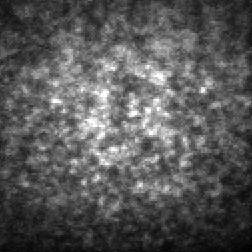
- surface density is high: you can't distinguish single molecules in your data
- INPUT:
  - bulk image (.SPE file, frame defined by 'bulk_start_frame'): surface density is determined from bulk image
  - single-molecule data (.h5 file, frames determined by 'sm_start_frame' and 'sm_final_frame') to determine single molecule brightness and background noise

In [12]:
#uplod brightness and background column from the localization table, make an average

single_molecule_mean=[]
bg_mean=[]

for i in range(0,len(data_loc)):
    
    data_signal=data_loc[i]['mass']
    single_molecule_mean.append(np.mean(data_signal))

    
    data_bg=data_loc[i]['bg']
    bg_mean.append(np.mean(data_bg))

print(single_molecule_mean, bg_mean)

[11112.246546078022, 11829.952485291953, 11221.461374495446, 8459.20014950053, 9388.973512375667, 11280.729866623398, 9958.24481807252, 11320.36274573766, 11706.970250038825, 12986.199498996966] [1369.4598685591159, 1383.1933307925892, 1289.7898955301266, 1415.2838219913256, 1177.975566946149, 1283.102864005562, 1305.2595332546796, 1187.2574245512671, 1358.5518559987686, 1138.5556306195592]


In [13]:
#exchange nan value in the brightness and background list for 0 value

nanlist_sm=[]
nanlist_bcg=[]

for i in range(0,len(single_molecule_mean)):
    if np.isnan(single_molecule_mean[i])== True:
        nanlist_sm.append(0)
    else:
        nanlist_sm.append(single_molecule_mean[i])

    if np.isnan(bg_mean[i])== True:
        nanlist_bcg.append(0)
    else:
        nanlist_bcg.append(bg_mean[i])
        
single_molecule_mean=nanlist_sm
bg_mean=nanlist_bcg

print(single_molecule_mean, bg_mean)

[11112.246546078022, 11829.952485291953, 11221.461374495446, 8459.20014950053, 9388.973512375667, 11280.729866623398, 9958.24481807252, 11320.36274573766, 11706.970250038825, 12986.199498996966] [1369.4598685591159, 1383.1933307925892, 1289.7898955301266, 1415.2838219913256, 1177.975566946149, 1283.102864005562, 1305.2595332546796, 1187.2574245512671, 1358.5518559987686, 1138.5556306195592]


In [14]:
#upload bulk image, defined by 'bulk_start_frame'
data_imgs=[]

for i in range(0,len(data_files)):
    with io.ImageSequence(data_files[i]) as ims:

        img = ims[bulk_start_frame]
        data_imgs.append(img)

print(np.shape(img), len(data_imgs))

(155, 424) 10


In [15]:
#assign roi to all images, calculate overall intensity over roi
images_roi = [np.sum(roi_imagej(i)) for i in data_imgs]

#calculate mean from all overall intensities over rois
mean_int_roi=np.mean(images_roi)

print(images_roi, '\n','mean intensity per bulk frame (roi):', mean_int_roi)

[1403594, 1397574, 1398889, 1400573, 1395898, 1395753, 1405714, 1400321, 1399432, 1397208] 
 mean intensity per bulk frame (roi): 1399495.6


In [16]:
#intensity per um^2

mean_int_1um=mean_int_roi/(size_um[0]*size_um[1])
print('mean overall intensity:' ,mean_int_roi, ', per roi of size:',size_um, '=', size_um[0]*size_um[1],'um2' )
print('mean overall intensity per 1um2:', mean_int_1um)



mean overall intensity: 1399495.6 , per roi of size: [14.4, 11.200000000000001] = 161.28000000000003 um2
mean overall intensity per 1um2: 8677.428075396825


In [19]:
#surface density
surface_density_bg=np.round((mean_int_1um-(np.mean(bg_mean)*6.25*6.25))/np.mean(single_molecule_mean),2)

print('surface density from bulk data (high-density samples)):  '+str(surface_density_bg)+' molecules/um^2')

surface density from bulk data (high-density samples):  -47.35 molecules/um^2


### high SLB occupancy: final plot

- surface density is determined and ploted for each measured position within one well
- average surface density and error of the mean for one-well data is calculated
- the final plot is saved in the 'data_dir' folder defined by user

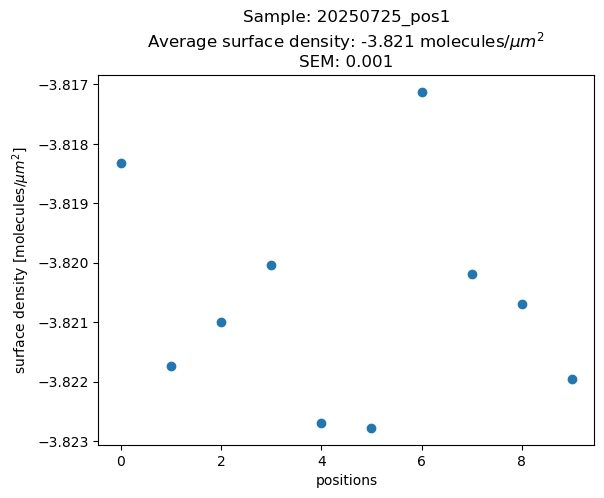

In [18]:
surface_density_bg_list=[]

for i in range(0,len(images_roi)):
    surface_density_bg_list.append(((images_roi[i]/(size_um[0]*size_um[1]))-(np.mean(bg_mean)*6.25*6.25))/np.mean(single_molecule_mean))

    #surface_density_bg=np.round((mean_int_1um-(np.mean(bg_mean)*6.25*6.25))/np.mean(single_molecule_mean),2)

fig, ax = plt.subplots()

plt.plot(surface_density_bg_list, 'o')

plt.xlabel('positions')
plt.ylabel('surface density [molecules/$\mu m^2$]')
plt.title('Sample: '+str(data_filename[0])+ '\n'+'Average surface density: '+str(np.round(np.mean(surface_density_bg_list),3))+' molecules/$\mu m^2$' + '\n'+'SEM: ' + str(np.round(np.std(surface_density_bg_list)/np.sqrt(np.size(surface_density_bg_list)),3)))
fig.savefig(f'{data_dir}/'+data_filename[0]+"_density.png",bbox_inches='tight')

plt.show()

## low SLB occupancy
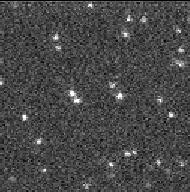

- surface density is low → a few number of signals in your field of view, you can distinguish single molecules
- INPUT:
  - single-molecule data (.h5 file, frames determined by 'sm_start_frame' and 'sm_final_frame') to read out the number of molecules within the chosen frames, surface density is corrected by roi size

In [20]:
localization=[]


#uplod "frame" column from the localization table, save number of localization per frame as a list
for i in range(0,len(data_loc)):
    for j in range(sm_start_frame,sm_final_frame+1):
        data_loc_mask=pd.DataFrame(data_loc[i])['frame']==j
        data_localization=data_loc[i]['frame'][data_loc_mask]
        localization.append(len(data_localization))
    
    
surface_density_nobleach=np.round((np.mean(localization)/(size_um[0]*size_um[1])),5)

print('surface density from single-molecule .h5 data (low-density samples)):  '+str(surface_density_nobleach)+' molecules/um^2')

surface density from single-molecule .h5 data (low-density samples)):  1.80866 molecules/um^2


### low SLB occupancy: final plot

- surface density is determined and ploted for each measured position within one well
- average surface density and error of the mean for one-well data is calculated
- the final plot is saved in the 'data_dir' folder defined by user

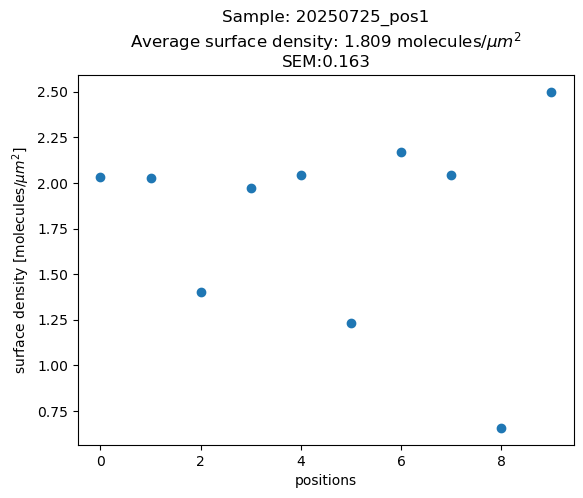

In [21]:
surface_density_nobleach_list=[]

for i in localization:
    surface_density_nobleach_list.append(i/(size_um[0]*size_um[1]))


fig, ax = plt.subplots()

plt.plot(surface_density_nobleach_list, 'o')

plt.xlabel('positions')
plt.ylabel('surface density [molecules/$\mu m^2$]')
plt.title('Sample: '+str(data_filename[0])+ '\n'+'Average surface density: '+str(np.round((surface_density_nobleach),3))+' molecules/$\mu m^2$' + '\n'+'SEM:' + str(np.round(np.std(surface_density_nobleach_list)/np.sqrt(np.size(surface_density_nobleach_list)),3)))
fig.savefig(f'{data_dir}/'+data_filename[0]+"_density.png",bbox_inches='tight')

plt.show()

# surface density: clusters
- for oligomeric proteins, origami platforms with more than one fluorophore, etc.
- for monomeric molecules, **if bulk image (non-bleached data) is saved separately from single-molecule data (bleached data)**

- INPUT
     - bulk image (.SPE file, frame defined by 'bulk_start_frame'): surface density is determined from bulk image
     - single-molecule data (.h5 file, frames determined by 'sm_start_frame' and 'sm_final_frame') to determine single molecule brightness and background noise



### User input:

1) set the data directory, filename and frames to be analyzed (bulk data and single-molecule data)

In [29]:
#data path for single-molecule data
data_sm= r"/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/mSA/dilution1"

#data path for bulk data
data_bulk=r"/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/positive"


#single-molecule data filename(s)
data_files_sm_filename=['20250725_msa_dil1']
data_files_sm = sorted(Path(data_sm).glob(data_files_sm_filename[0]+"*.SPE")) #.SPE


#bulk data filename(s)
data_bulk_filename=['20250725_pos1']
data_files_bulk = sorted(Path(data_bulk).glob(data_bulk_filename[0]+"*.SPE"))


#which frames I want to use for single-molecula data
sm_start_frame=4
sm_final_frame=4

#which frame is the bulk data
bulk_start_frame=0
 


In [30]:
print(len(data_files_sm), len(data_files_bulk))#,len(data_files_bcg))

10 10


2) choose the roi in the image-j (aim for homogenous illumination in your roi), insert the coordinates here

In [31]:
#coordinates of top left corner of the chosen roi
top_left=[290,40]

#coordinates of bottom right corner of the chosen roi
bottom_right=[380,110]


3) here, the roi size is calculated and respective roi is cut from the raw data and saved as .tiff file

In [32]:
#create roi based on image-j coordinates
roi_imagej = roi.ROI((top_left[0], top_left[1]), (bottom_right[0], bottom_right[1]))

#size of the chosen roi in um, based on the coordinates from imagej
size=[bottom_right[0]-top_left[0],bottom_right[1]-top_left[1]]

#size of the chosen roi in um, based on the coordinates from imagej/image size
size_um=[size[0]*0.160, size[1]*0.160]
    
print('ROI size in pixels:  '+ str(size)+'\n' +'ROI size in um:  '+ str(size_um))

#cut & save roi of the data
data_imgs = [io.ImageSequence(b).open() for b in data_files_sm]

#assign left and right roi to all stacks
data_roi = [roi_imagej(i) for i in data_imgs]


for i in range(0, len(data_files_sm)):
    io.save_as_tiff(f'{data_sm}/'+data_files_sm_filename[0]+'_roi_'+str(i)+'.tiff', data_roi[i])
   

ROI size in pixels:  [90, 70]
ROI size in um:  [14.4, 11.200000000000001]


4) use locator to localize single-molecule data (.tiff or .SPE files)

In [8]:
#localization 
sys.executable
subprocess.run([sys.executable, "-m", "sdt.gui.locator"])
 

/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
Exception ignored in: <function Pool.__del__ at 0x159848f70>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/sdt-env/lib/python3.10/multiprocessing/pool.py", line 271, in __del__
  File "/opt/anac

CompletedProcess(args=['/opt/anaconda3/envs/sdt-env/bin/python', '-m', 'sdt.gui.locator'], returncode=0)

### single-molecule data
- here, the localization data (.h5 files) will be uploaded. Note, that only frames within 'sm_start_frame' and 'sm_final_frame' are loaded. 

In [33]:
#read and load the localization file
data=sorted(Path(data_sm).glob(data_files_sm_filename[0]+'*.h5'))
data_load_sm = [io.load(f) for f in data]


data_loc_sm=[]

for i in range(0, len(data_load_sm)):
    data_loc_sm.append(data_load_sm[i][data_load_sm[i]['frame'].between(sm_start_frame, sm_final_frame, inclusive='both')])
     

In [34]:
#uplod brightness and background column from the localization table, make an average
single_molecule_mean=[]
single_molecule_bg=[]

for i in range(0,len(data_loc_sm)):

    #brightness data
    data_signal=data_loc_sm[i]['mass']
    single_molecule_mean.append(np.mean(data_signal))
    
    #background data
    data_bg=data_loc_sm[i]['bg']
    single_molecule_bg.append(np.mean(data_bg))

print(single_molecule_mean,single_molecule_bg)
 

[3634.284455114192, 3755.4088410383265, 3305.3777697866335, 3963.281766211719, 2690.795103370592, 3032.0835875018392, 3518.9769594496433, 3186.293491217484, 3593.434851935913, 3468.172127864475] [328.8902601852706, 316.9898859274678, 356.69952018809585, 332.48787321196204, 320.33623232711955, 330.0991155489533, 326.4945556503732, 337.92585321896905, 352.4020147191114, 349.88305863520475]


### bulk data
- here, the bulk data (.SPE files) will be uploaded. Note, that only frame defined by 'bulk_start_frame' is used

In [35]:
#upload 1st image of the movie
data_imgs_bulk=[]

for i in range(0,len(data_files_bulk)):
    with io.ImageSequence(data_files_bulk[i]) as ims:
        img = ims[bulk_start_frame]
        data_imgs_bulk.append(img)

print(np.shape(img), len(data_imgs_bulk))
 

(155, 424) 10


In [36]:
#assign roi to all images, calculate overall intensity over roi
bulk_roi = [np.sum(roi_imagej(i)) for i in data_imgs_bulk]

#calculate mean from all overall intensities over rois
mean_int_bulk=np.mean(bulk_roi)

print(bulk_roi, '\n','mean intensity per bulk (roi):', mean_int_bulk)
 

[1403594, 1397574, 1398889, 1400573, 1395898, 1395753, 1405714, 1400321, 1399432, 1397208] 
 mean intensity per bulk (roi): 1399495.6


In [37]:
#surface density: sm data as background

surface_density_clusters_sm=np.round(((mean_int_bulk/(size_um[0]*size_um[1]))-(np.mean(single_molecule_bg)/(0.160*0.160)))/(np.mean(single_molecule_mean)),2)

print('surface density (background defined from single-molecule .h5 data):  '+str(surface_density_clusters_sm)+' molecules/um^2')
 

surface density (background defined from single-molecule .h5 data):  -1.29 molecules/um^2


### surface density clusters: final plot

- surface density is determined and ploted for each measured position within one well
- average surface density and error of the mean for one-well data is calculated
- the final plot is saved in the 'data_bulk' folder defined by user

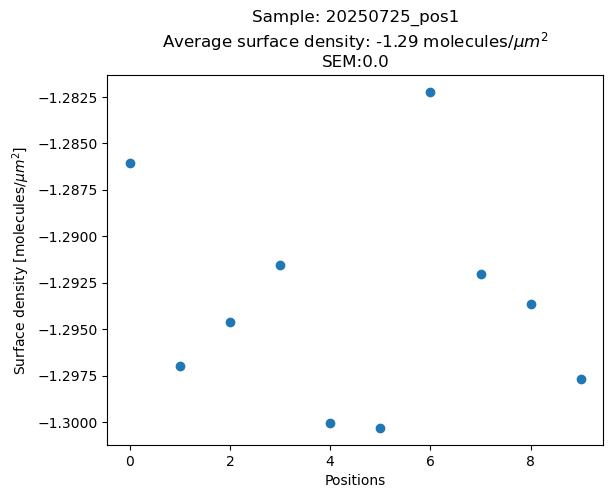

In [38]:
bulk_roi_list=[]

for i in bulk_roi:
   # bulk_roi_list.append(i/(size_um[0]*size_um[1]))
    bulk_roi_list.append(((i/(size_um[0]*size_um[1]))-(np.mean(single_molecule_bg)/(0.160*0.160)))/(np.mean(single_molecule_mean)))


fig, ax = plt.subplots()

plt.plot(bulk_roi_list, 'o')

plt.xlabel('Positions')
plt.ylabel('Surface density [molecules/$\mu m^2$]')
plt.title('Sample: '+str(data_bulk_filename[0]) +'\n' 'Average surface density: '+str(surface_density_clusters_sm)+' molecules/$\mu m^2$' + '\n'+'SEM:' + str(np.round(np.std(bulk_roi_list)/np.sqrt(np.size(bulk_roi_list)),2)))
fig.savefig(f'{data_bulk}/'+data_bulk_filename[0]+"_density.png",bbox_inches='tight')

plt.show()
 

3 | Bulk 210min (SM 220min) -> MeanDensity: 23.41, SEM: 0.26
3 | Bulk 230min (SM 220min) -> MeanDensity: 24.81, SEM: 0.25
3 | Normierungsfaktor: 23.41


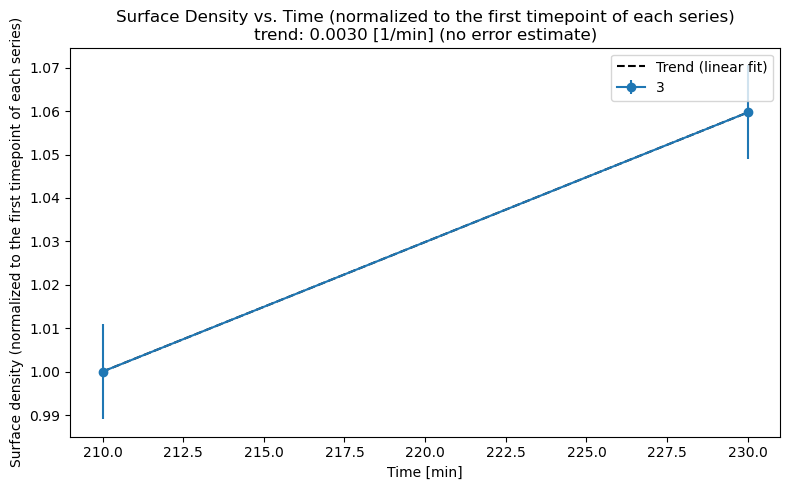

Gesamtplot mit Trendlinie gespeichert unter: /Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250623_origami_37/400ng/3/surface_density_vs_time_ALL.png


In [134]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sdt import io, roi
import re
import os
import warnings

warnings.filterwarnings("ignore", message="The file header of .*SPE claims there are .* frames, but there are actually .* frames.")

data_sm_dirs = [
    r"/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250623_origami_37/10ng/Asm"
]
data_bulk_dirs = [
r"/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250623_origami_37/400ng/3"
]
series_labels = ["3"]

sm_start_frame = 0
sm_final_frame = 0
bulk_start_frame = 0
top_left = [0, 0]
bottom_right = [128, 128]
roi_imagej = roi.ROI((top_left[0], top_left[1]), (bottom_right[0], bottom_right[1]))
size = [bottom_right[0] - top_left[0], bottom_right[1] - top_left[1]]
size_um = [size[0] * 0.160, size[1] * 0.160]

def extract_time_from_filename(fname):
    m = re.search(r"_(\d+)min", fname)
    return int(m.group(1)) if m else None

# Sammler für Trendlinie
all_plot_times = []
all_densities_time = []

# === Datenauswertung wie gehabt, aber noch kein Plot! ===
series_data = []
for idx, (data_sm, data_bulk) in enumerate(zip(data_sm_dirs, data_bulk_dirs)):
    sm_h5_files = sorted(Path(data_sm).glob("*.h5"))
    sm_time_to_files = dict()
    for f in sm_h5_files:
        t = extract_time_from_filename(f.name)
        if t is not None:
            sm_time_to_files.setdefault(t, []).append(f)
    sm_times = sorted(sm_time_to_files.keys())

    bulk_spe_files = sorted(Path(data_bulk).glob("*.SPE"))
    bulk_time_to_files = dict()
    for f in bulk_spe_files:
        t = extract_time_from_filename(f.name)
        if t is not None:
            bulk_time_to_files.setdefault(t, []).append(f)
    bulk_times = sorted(bulk_time_to_files.keys())

    raw_densities = []
    raw_sems = []
    plot_times = []

    for t_bulk in bulk_times:
        t_sm = min(sm_times, key=lambda x: abs(x - t_bulk))
        smfiles = sm_time_to_files[t_sm]
        bulkfiles = bulk_time_to_files[t_bulk]

        data_load_sm = [io.load(f) for f in smfiles]
        data_loc_sm = []
        for i in range(len(data_load_sm)):
            df = data_load_sm[i]
            data_loc_sm.append(df[df['frame'].between(sm_start_frame, sm_final_frame, inclusive='both')])
        single_molecule_mean = []
        single_molecule_bg = []
        for df in data_loc_sm:
            single_molecule_mean.append(np.mean(df['mass']))
            single_molecule_bg.append(np.mean(df['bg']))

        data_imgs_bulk = []
        for f in bulkfiles[:10]:
            ims_obj = io.ImageSequence(f)
            ims = ims_obj.open()
            try:
                img = ims[bulk_start_frame]
                data_imgs_bulk.append(img)
            finally:
                ims.close()
                ims_obj.close()
        bulk_roi = [np.sum(roi_imagej(i)) for i in data_imgs_bulk]

        bulk_roi_list = [
            ((i/(size_um[0]*size_um[1]))-(np.mean(single_molecule_bg)/(0.160*0.160))) / (np.mean(single_molecule_mean))
            for i in bulk_roi
        ]

        mean_density = np.mean(bulk_roi_list)
        sem_density = np.std(bulk_roi_list) / np.sqrt(len(bulk_roi_list)) if bulk_roi_list else np.nan
        raw_densities.append(mean_density)
        raw_sems.append(sem_density)
        plot_times.append(t_bulk)

        print(f"{series_labels[idx]} | Bulk {t_bulk}min (SM {t_sm}min) -> MeanDensity: {mean_density:.2f}, SEM: {sem_density:.2f}")
        
    # === Normierung auf ersten Wert der Dichte-Zeitreihe ===
    raw_densities = np.array(raw_densities)
    raw_sems = np.array(raw_sems)
    norm_factor = raw_densities[0] if raw_densities[0] != 0 else 1  # Schutz gegen Division durch 0
    densities_time = raw_densities / norm_factor
    sems_time = raw_sems / norm_factor

    print(f"{series_labels[idx]} | Normierungsfaktor: {norm_factor:.2f}")

    # Für späteren Plot und Trendlinie merken:
    series_data.append((plot_times, densities_time, sems_time, series_labels[idx]))
    all_plot_times.extend(plot_times)
    all_densities_time.extend(densities_time)

# === GESAMTPLOT erzeugen, anzeigen und speichern ===
plt.figure(figsize=(8, 5))

for plot_times, densities_time, sems_time, label in series_data:
    plt.errorbar(plot_times, densities_time, yerr=sems_time, fmt='o-', label=label)

# Trendlinie mit Unsicherheit (robust auch bei wenigen Punkten)
x = np.array(all_plot_times)
y = np.array(all_densities_time)
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]

if len(x) > 2:  # mind. 3 Punkte für Fit mit Unsicherheitsabschätzung
    coef, cov = np.polyfit(x, y, 1, cov=True)
    p = np.poly1d(coef)
    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = p(x_fit)
    plt.plot(x_fit, y_fit, 'k--', label='Trend (linear fit)')
    slope = coef[0]
    slope_err = np.sqrt(cov[0, 0])
    plt.title(f"Surface Density vs. Time (normalized to the first timepoint of each series)\n"
              f"trend: {slope:.4f} ± {slope_err:.4f} [1/min]")
elif len(x) == 2:  # nur Fit ohne Fehler möglich
    coef = np.polyfit(x, y, 1)
    p = np.poly1d(coef)
    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = p(x_fit)
    plt.plot(x_fit, y_fit, 'k--', label='Trend (linear fit)')
    slope = coef[0]
    plt.title(f"Surface Density vs. Time (normalized to the first timepoint of each series)\n"
              f"trend: {slope:.4f} [1/min] (no error estimate)")
else:
    plt.title('Surface Density vs. Time (insufficient data for trend)')

plt.xlabel('Time [min]')
plt.ylabel('Surface density (normalized to the first timepoint of each series)')
plt.legend()
plt.tight_layout()
plt.show()

# === Speichern ===
def get_common_path(paths):
    from os.path import commonpath
    return commonpath(paths)
parent_folder = get_common_path(data_bulk_dirs)
out_plot_path = os.path.join(parent_folder, "surface_density_vs_time_ALL.png")
plt.figure(figsize=(8, 5))
for plot_times, densities_time, sems_time, label in series_data:
    plt.errorbar(plot_times, densities_time, yerr=sems_time, fmt='o-', label=label)
if len(x) > 1:
    plt.plot(x_fit, y_fit, 'k--', label='Trend (linear fit)')
    plt.title(f"Surface Density vs. Time (normalized to the first timepoint of each series)\n"
              f"trend: {slope:.4f} ± {slope_err:.4f} [1/min]")
else:
    plt.title('Surface Density vs. Time (all data)')
plt.xlabel('Time [min]')
plt.ylabel('Surface density (normalized to the first timepoint of each series)')
plt.legend()
plt.tight_layout()
plt.savefig(out_plot_path, bbox_inches='tight')
plt.close()
print(f"Gesamtplot mit Trendlinie gespeichert unter: {out_plot_path}")
